In [1]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier, AdaBoostClassifier)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
df = pd.read_excel("Данные_для_курсовои_Классическое_МО.xlsx")
df.head()

,Unnamed: 0,"IC50, mM","CC50, mM",SI,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,0,6.239374,175.482382,28.125000,5.094096,5.094096,0.387225,0.387225,0.417362,42.928571,...,0,0,0,0,0,0,0,0,3,0
1,1,0.771831,5.402819,7.000000,3.961417,3.961417,0.533868,0.533868,0.462473,45.214286,...,0,0,0,0,0,0,0,0,3,0
2,2,223.808778,161.142320,0.720000,2.627117,2.627117,0.543231,0.543231,0.260923,42.187500,...,0,0,0,0,0,0,0,0,3,0
3,3,1.705624,107.855654,63.235294,5.097360,5.097360,0.390603,0.390603,0.377846,41.862069,...,0,0,0,0,0,0,0,0,4,0
4,4,107.131532,139.270991,1.300000,5.150510,5.150510,0.270476,0.270476,0.429038,36.514286,...,0,0,0,0,0,0,0,0,0,0


In [6]:
# удалим данные для дальнейшей обработки
cols_to_drop= ['CC50, mM', 'IC50, mM', 'Unnamed: 0']
df = df.drop(cols_to_drop, axis=1)

Согласно иследованию EDA

Топ-10 наиболее важных дескрипторов для SI:

VSA_EState6            0.436771

VSA_EState2            0.073177

MinPartialCharge       0.046888

BalabanJ               0.039939

qed                    0.036372

MaxAbsPartialCharge    0.035627

VSA_EState8            0.015990

VSA_EState9            0.013150

BCUT2D_MRLOW           0.010328

FpDensityMorgan1       0.009884

### Подготовка данных и обработка выбросов

Уберем выбросы по SI, рассчитаем среднее и создадим новый признак, который станет у нас целевой пременной

In [7]:
original_count = len(df)
print(f"Исходное количество записей: {original_count}")

mean_cc50 = df['SI'].mean()
std_cc50 = df['SI'].std()
lower_bound = mean_cc50 - 2 * std_cc50
upper_bound = mean_cc50 + 2 * std_cc50

df = df[(df['SI'] >= lower_bound) & (df['SI'] <= upper_bound)].copy()
filtered_count = len(df)
print(f"Количество записей после удаления выбросов: {filtered_count}")
print(f"Удалено записей: {original_count - filtered_count}")

# Создание целевой переменной
df['SI_Above_8'] = (df['SI'] > 8).astype(int)
target = 'SI_Above_8'

Исходное количество записей: 1001
Количество записей после удаления выбросов: 993
Удалено записей: 8


### Инжиниринг признаков

In [8]:
cols_to_exclude = ['IC50, mM', 'CC50, mM', 'SI', target]
X = df.drop(columns=[col for col in cols_to_exclude if col in df.columns], errors='ignore')
y = df[target]

df_engineered = X.copy()

if 'MolLogP' in df_engineered.columns and 'MolWt' in df_engineered.columns:
    df_engineered['MolLogP_x_MolWt'] = df_engineered['MolLogP'] * df_engineered['MolWt']

polynomial_features_cols = ['MolLogP', 'MolWt']
existing_poly_cols = [col for col in polynomial_features_cols if col in df_engineered.columns]

if existing_poly_cols:
    poly = PolynomialFeatures(degree=2, include_bias=False)
    poly_features = poly.fit_transform(df_engineered[existing_poly_cols])
    poly_feature_names = poly.get_feature_names_out(existing_poly_cols)

    new_poly_df = pd.DataFrame(poly_features, columns=poly_feature_names, index=df_engineered.index)
    for col in new_poly_df.columns:
        if col not in df_engineered.columns:
            df_engineered[col] = new_poly_df[col]

if 'MolLogP' in df_engineered.columns:
    df_engineered['MolLogP_gt_3'] = (df_engineered['MolLogP'] > 3).astype(int)

if df_engineered.isnull().values.any():
    imputer = SimpleImputer(strategy='median')
    df_engineered = pd.DataFrame(imputer.fit_transform(df_engineered),
                               columns=df_engineered.columns)

### Определение моделей и функции оценки

In [9]:
classification_models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'KNN': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'HistGradientBoosting': HistGradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss'),
    'CatBoost': CatBoostClassifier(random_state=42, verbose=0),
    'Stacking': StackingClassifier(
        estimators=[
            ('rf', RandomForestClassifier(random_state=42)),
            ('xgb', XGBClassifier(random_state=42)),
            ('gb', GradientBoostingClassifier(random_state=42))
        ],
        final_estimator=LogisticRegression(),
        passthrough=True
    )
}

def evaluate_classifier(model, X, y):
    """
    Обучает и оценивает модель классификации.
    Выводит метрики и визуализирует матрицу ошибок.

    """
    #  Разделение на обучающую и тестовую выборки
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    #  Обучение модели
    model.fit(X_train, y_train)

    #  Предсказания
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None

    #  Расчёт метрик
    metrics = {
        'Model': type(model).__name__,
        'Accuracy': accuracy_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred, zero_division=0),
        'Precision': precision_score(y_test, y_pred, zero_division=0),
        'Recall': recall_score(y_test, y_pred, zero_division=0),
        'ROC AUC': roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan
    }

    #  Матрица ошибок
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Предсказанный класс')
    plt.ylabel('Истинный класс')
    plt.title(f'{type(model).__name__} - Confusion Matrix')
    plt.tight_layout()
    plt.show()

    return metrics

### Обучение и оценка моделей


 Обучение модели: Logistic Regression


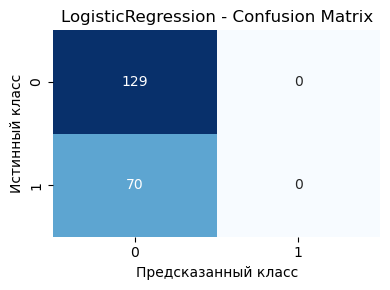


 Обучение модели: KNN


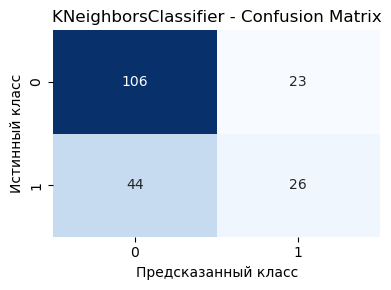


 Обучение модели: Random Forest


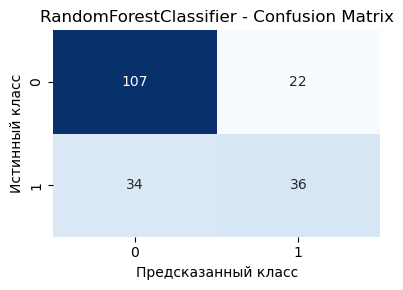


 Обучение модели: Gradient Boosting


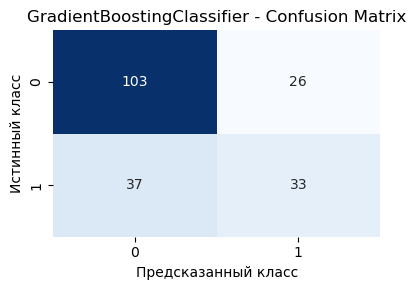


 Обучение модели: HistGradientBoosting


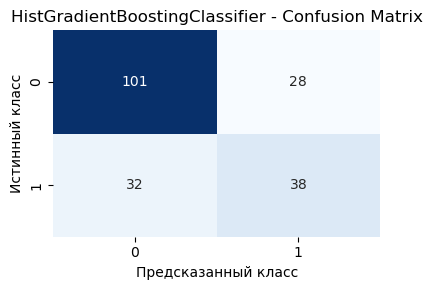


 Обучение модели: XGBoost


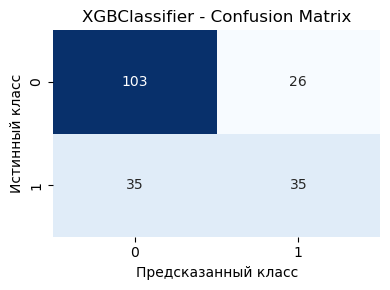


 Обучение модели: CatBoost


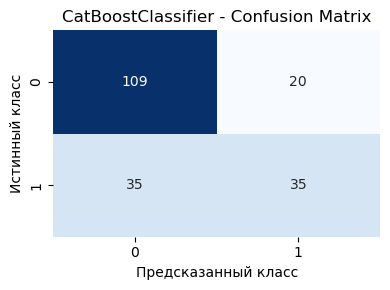


 Обучение модели: Stacking


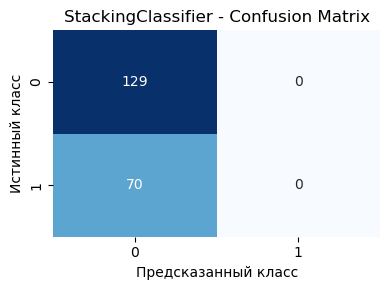

C:\Users\NikLeo\AppData\Local\Temp\ipykernel_19528\1295609280.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


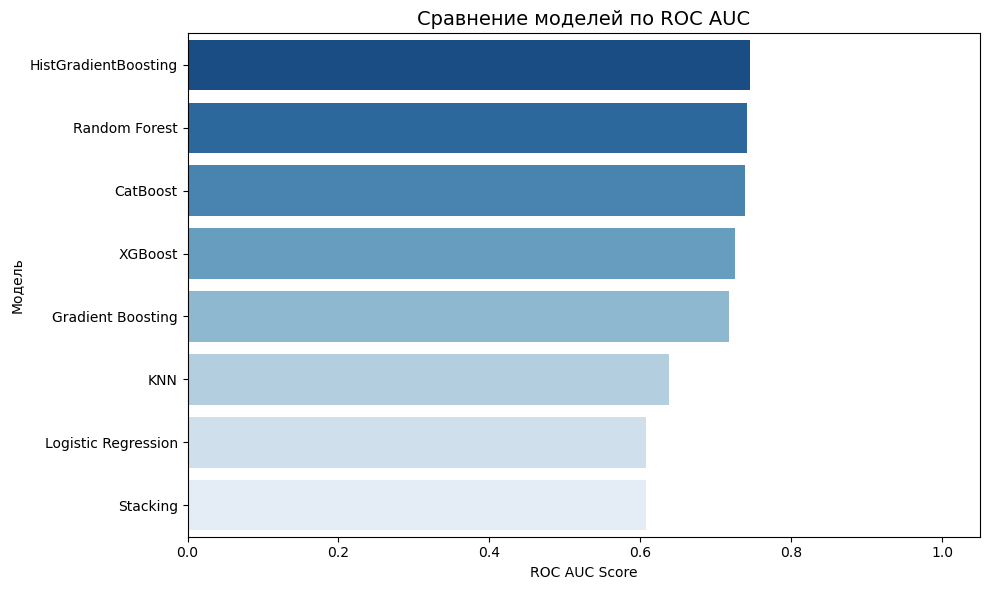


 Итоговые метрики моделей:


,Model,Accuracy,F1,Precision,Recall,ROC AUC
4,HistGradientBoosting,0.698,0.559,0.576,0.543,0.745
2,Random Forest,0.719,0.562,0.621,0.514,0.741
6,CatBoost,0.724,0.560,0.636,0.500,0.738
5,XGBoost,0.693,0.534,0.574,0.500,0.726
3,Gradient Boosting,0.683,0.512,0.559,0.471,0.717
1,KNN,0.663,0.437,0.531,0.371,0.638
0,Logistic Regression,0.648,0.000,0.000,0.000,0.607
7,Stacking,0.648,0.000,0.000,0.000,0.607


In [10]:
#  Сравнение моделей классификации

results = []
best_model = None
best_roc_auc = -np.inf  # Начальное значение для сравнения ROC AUC

for name, model in classification_models.items():
    try:
        print(f"\n Обучение модели: {name}")
        metrics = evaluate_classifier(model, df_engineered, y)  # df_engineered — таблица признаков
        metrics['Model'] = name
        results.append(metrics)

        # Обновляем лучшую модель по метрике ROC AUC
        if metrics['ROC AUC'] > best_roc_auc:
            best_roc_auc = metrics['ROC AUC']
            best_model = model

    except Exception as e:
        print(f" Ошибка при обучении {name}: {str(e)}")

#  Сводная таблица результатов
results_df = pd.DataFrame(results).sort_values(by='ROC AUC', ascending=False).round(3)

#  График сравнения моделей по ROC AUC
plt.figure(figsize=(10, 6))
sns.barplot(
    y='Model',
    x='ROC AUC',
    data=results_df,
    palette='Blues_r'
)
plt.title('Сравнение моделей по ROC AUC', fontsize=14)
plt.xlabel('ROC AUC Score')
plt.ylabel('Модель')
plt.xlim(0, 1.05)
plt.tight_layout()
plt.show()

#  Таблица с подсветкой лучших и худших значений ROC AUC
def display_beautiful_table(df):
    styles = [
        {'selector': 'th', 'props': [('background-color', '#343a40'),
                                     ('color', 'white'),
                                     ('font-weight', 'bold'),
                                     ('text-align', 'center')]},
        {'selector': 'td', 'props': [('text-align', 'center')]},
        {'selector': 'tr:nth-of-type(odd)', 'props': [('background-color', '#f9f9f9')]},
        {'selector': 'tr:hover', 'props': [('background-color', '#ffffcc')]}
    ]
    return (df.style
              .set_table_styles(styles)
              .format({
                  'Accuracy': '{:,.3f}',
                  'ROC AUC': '{:,.3f}',
                  'F1': '{:,.3f}',
                  'Precision': '{:,.3f}',
                  'Recall': '{:,.3f}'
              })
              .highlight_max(subset=['ROC AUC'], color='green')  # зелёный для лучших
              .highlight_min(subset=['ROC AUC'], color='red'))  # красный для худших

#  Вывод таблицы
print("\n Итоговые метрики моделей:")
display(display_beautiful_table(results_df))

In [11]:
import joblib

# Сохранение лучшей модели
if best_model is not None:
    # Название лучшей модели из таблицы результатов
    best_model_name = results_df.iloc[0]['Model']
    
    # Имя файла с учетом модели
    filename = f'best_model_Si-8_{best_model_name}.pkl'
    
    # Сохраняем модель с помощью joblib
    joblib.dump(best_model, filename)
    
    print(f"\n Лучшая модель '{best_model_name}' сохранена в файл: {filename}")
else:
    print(" Не удалось сохранить модель: лучшая модель не найдена.")



 Лучшая модель 'HistGradientBoosting' сохранена в файл: best_model_Si-8_HistGradientBoosting.pkl


### Выводы

Модель HistGradientBoosting продемонстрировала наилучшие результаты среди протестированных алгоритмов, достигнув ROC AUC = 0.745, что указывает на её уверенное различие между классами. Остальные метрики — Accuracy = 69.8%, F1-score = 0.559, Precision = 0.576 и Recall = 0.543 — находятся на приемлемом уровне и показывают умеренное качество предсказаний. 

Модели Random Forest и CatBoost показали сопоставимые результаты с ROC AUC около 0.74, но немного уступили лидеру по полноте (Recall). CatBoost, в частности, обеспечил высокую точность положительных предсказаний (Precision = 0.636), что говорит о низком числе ложноположительных классификаций. Эти ансамблевые методы остаются одними из наиболее стабильных решений для задач классификации в задачах с множественными признаками.

XGBoost и Gradient Boosting продемонстрировали чуть более скромные результаты, с ROC AUC в пределах 0.717–0.726, и менее сбалансированными метриками F1 и Recall. Несмотря на это, они остаются рабочими решениями и могут быть улучшены с помощью дополнительной настройки гиперпараметров или отбора признаков.

Наименее эффективными оказались модели KNN, Logistic Regression и Stacking. Особенно слабый результат показали логистическая регрессия и стекинг, полностью провалив предсказания положительного класса (F1 = 0.000, Precision = 0.000, Recall = 0.000), что делает их непригодными в текущем виде. Модель KNN, хотя и продемонстрировала частичную способность к классификации, оказалась нестабильной на сложных данных с высокой размерностью.